## This notebook deals with the Sentiment Analysis of Tweets posted during 2019 Canadian Elections. We will build several models to check which one works best and try answering the question - "What can public opinion on Twitter tell us about the Canadian political landscape in 2019?"

## The notebook can be broadly divided into following sections:

### a) Data Cleaning
### b) Exploratory Data Analysis
### c) Model Preparation
### d) Model Implementation
### e) Results

#### We will begin with initilializing the libraries and feeding the dataset

## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

## For Cleaning and Decoding
import re
import html
import unicodedata
import string

## For Preparing Features to Model
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


## For Bonus Section
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

## For Data Exploration
try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
    from wordcloud import WordCloud

## For building models    
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

from sklearn.naive_bayes import MultinomialNB

## For evaluating models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anmol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating DataSets -> 

**1. tweets_df (containing general tweets)**

**2. canadian_elections_2019_df (containing tweets on Canadian Elections 2019)**

In [2]:
## Loading Datasets
tweets_df=pd.read_csv('generic_tweets.txt')
canadian_elections_2019_df = pd.read_csv('Canadian_elections_2019.csv', encoding='utf-8')


## Loading stopwords to filter words while cleaning the tweets
stop_words = open('stop_words.txt','r').read()

## Taking a look at the general tweets
tweets_df

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
199995,4,1693956088,Mon May 04 00:27:13 PDT 2009,NO_QUERY,FelineBred,"@jvdouglas haha, no, the remark on maternity ..."
199996,4,1693956096,Mon May 04 00:27:14 PDT 2009,NO_QUERY,softthistle,@altitis and to you!
199997,4,1693956099,Mon May 04 00:27:14 PDT 2009,NO_QUERY,elysion32,Okie doke!! Time for me to escape for the Nort...
199998,4,1693956134,Mon May 04 00:27:14 PDT 2009,NO_QUERY,fancyjessy,"finished the lessons, hooray!"


In [3]:
canadian_elections_2019_df   ## Taking a look at the Canadian Election tweets

## Note: the tweets (i.e. text column) are in bytes format

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."
...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...


#### Creating a copy of the datasets to make changes into and preserving the original datasets

In [4]:
tw_df_copy=tweets_df.copy()
can_ele_2019_copy=canadian_elections_2019_df.copy()

## Part A : Data Cleaning

### 1. Dropping unwanted columns

**As we can see that the columns - [id, date, query, user] will not be participating in the modeling, we will drop these columns from our dataset**

In [5]:
tw_df_copy=tw_df_copy.drop(['id','date','query','user'],axis=1)
tw_df_copy

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
199995,4,"@jvdouglas haha, no, the remark on maternity ..."
199996,4,@altitis and to you!
199997,4,Okie doke!! Time for me to escape for the Nort...
199998,4,"finished the lessons, hooray!"


### 2. Cleaning the tweets (Part 1)

**Steps Involved:**
1. All text in lowercase
2. Removal of URL links and twitter handles
3. Removal of HTML attributes such as </>
4. Parsing of HTML character codes into their ASCII equivalent

In [6]:
def Clean_Gen(tweet):
    
    '''Function to clean General Tweets dataset'''
    
    tweet_comb = []
    
    word = tweet.lower()  # converting text into lowercase

    word = re.sub(r'http\S+', '', word)  # removing URL Links
    word = re.sub(r'www.\S+', '', word)

    word = re.sub(r'@\S+', '', word)  # removing twitter handles

    comp = re.compile(r'<\n>?]')
    word = re.sub(comp, '', word)  # removing HTML attributes

    word = html.unescape(word)  # converting HTML character codes into their ASCII Equivalent

    tweet_comb.append(word)
    
    return str(tweet_comb)

In [7]:
def Clean_Can(tweet):
    
    '''Function to clean General Tweets dataset'''
    
    tweet_comb=[]
    
    ## As Elections tweets are in bytes format, decoding the same in utf-8 format 
    tweet = eval(tweet).decode("utf-8", "ignore")

    word = tweet.lower()  # converting text into lowercase

    word = re.sub(r'http\S+', '', word)  # removing URL Links
    word = re.sub(r'www.\S+', '', word)

    word = word.replace('\n', '')  # removing '\n' from tweets

    comp = re.compile(r'<\>.]/+^-')
    word = re.sub(comp, '', word)  # removing HTML attributes

    word = html.unescape(word)  # converting HTML character codes into their ASCII Equivalent

    tweet_comb.append(word)
    
    return str(tweet_comb)

In [8]:
## Applying the respective functions on respective tweets of the datasets

tw_df_copy['text_clean'] = tw_df_copy['text'].apply(lambda x: Clean_Gen(x))

can_ele_2019_copy['text_clean'] = can_ele_2019_copy['text'].apply(lambda x: Clean_Can(x))

In [9]:
tw_df_copy  # Observe the change from original tweet to cleaned tweet

,class,text,text_clean
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","["" - awww, that's a bummer. you shoulda got ..."
1,0,is upset that he can't update his Facebook by ...,"[""is upset that he can't update his facebook b..."
2,0,@Kenichan I dived many times for the ball. Man...,[' i dived many times for the ball. managed to...
3,0,my whole body feels itchy and like its on fire,['my whole body feels itchy and like its on fi...
4,0,"@nationwideclass no, it's not behaving at all....","["" no, it's not behaving at all. i'm mad. why ..."
...,...,...,...
199995,4,"@jvdouglas haha, no, the remark on maternity ...","[' haha, no, the remark on maternity leave fi..."
199996,4,@altitis and to you!,[' and to you! ']
199997,4,Okie doke!! Time for me to escape for the Nort...,"[""okie doke!! time for me to escape for the no..."
199998,4,"finished the lessons, hooray!","['finished the lessons, hooray! ']"


In [10]:
can_ele_2019_copy  # Observe the change from original tweet to cleaned tweet

,sentiment,negative_reason,text,text_clean
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[""#allwomanspacewalk it's real!@space_station ..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[""#canada #canadaelection2019 #canadavotes #el..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin..."
...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,['your daily reminder:@thejagmeetsingh endorse...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,['yup...not going to reopen the abortion debat...


### 3. Cleaning the tweets (Part 2)

**Steps Involved:**
1. Tokenize the tweets
2. Filter out stopwords
3. Use SnowballStemmer to stem the remaininig words

**Token: Each “entity” that is a part of whatever was split up based on rules. For examples, each word is a token when a sentence is “tokenized” into words. Each sentence can also be a token, if you tokenized the sentences out of a paragraph.**

Source: https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/

**Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”). We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words**

Source: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

**Stemming: is the process of reducing words to their core root (for instance - cooking to cook, asked to ask).**
**As there can be understemming or overstemming of words, this process can affect the model. However, to reduce the processing time, we will perform stemming.**
**We use SnowballStemmer instead of PorterStemmer as it is a better stemmer and universally accepted.**

Source: https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8

In [11]:
## Cleaning General Tweets below

s1 = ' '
corpus_clean_gen = []

for line in tw_df_copy['text_clean']: 

    tokenizer = RegexpTokenizer(r'\w+') # Intializing Tokenizer based on white spaces rule     

    b = tokenizer.tokenize(line)
    words_rmStop = [word for word in b if word not in stopwords.words('english')] # removing stop words
    words_rmStop = [word for word in b if word not in stop_words]

    sb = SnowballStemmer(language='english')
    words_stem = [sb.stem(word) for word in words_rmStop] # stemming the tweets

    corpus_clean_gen.append(s1.join(words_stem))

In [12]:
## Cleaning Election Tweets below

s1 = ' '
corpus_clean_ele = []

for line in can_ele_2019_copy['text_clean']: 

    tokenizer = RegexpTokenizer(r'\w+') # Intializing Tokenizer based on white spaces rule        

    b = tokenizer.tokenize(line)
    words_rmStop = [word for word in b if word not in stopwords.words('english')] # removing stop words
    words_rmStop = [word for word in b if word not in stop_words]

    sb = SnowballStemmer(language='english')
    words_stem = [sb.stem(word) for word in words_rmStop] # stemming the tweets

    corpus_clean_ele.append(s1.join(words_stem))

In [13]:
## Appending the cleaned tweet into the datasets

tw_df_copy['text_clean_tokenized']=corpus_clean_gen
can_ele_2019_copy['text_clean_tokenized']=corpus_clean_ele

In [14]:
can_ele_2019_copy

,sentiment,negative_reason,text,text_clean,text_clean_tokenized
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[""#allwomanspacewalk it's real!@space_station ...",allwomanspacewalk space_st etobicokenorth city...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[""#canada #canadaelection2019 #canadavotes #el...",canada canadaelection2019 canadavot elxn43 dec...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...
...,...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,['your daily reminder:@thejagmeetsingh endorse...,daili remind thejagmeetsingh endors strateg vo...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,['yup...not going to reopen the abortion debat...,yup go reopen abort debat elxn43 scheer scheer...


## Part B: Exploration of Data (Exploratory Data Analysis)

**Now that the data has been cleaned, we will move forward with the exploration of data**

### 1. Assigning the political party (Liberal/Conservative/NDP) to a given tweet

In [15]:
## Creating a column to designate the political party

can_ele_2019_copy['political_party'] = '0'
can_ele_2019_copy

,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,0
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[""#allwomanspacewalk it's real!@space_station ...",allwomanspacewalk space_st etobicokenorth city...,0
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,0
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[""#canada #canadaelection2019 #canadavotes #el...",canada canadaelection2019 canadavot elxn43 dec...,0
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,0
...,...,...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,0
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,0
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,['your daily reminder:@thejagmeetsingh endorse...,daili remind thejagmeetsingh endors strateg vo...,0
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,['yup...not going to reopen the abortion debat...,yup go reopen abort debat elxn43 scheer scheer...,0


**Concept**

We will look for certain keywords in a tweet to classify the tweet with a political party.

1. Liberal : Keywords - 'justin|trudeau|justintrudeau|liberal|lpc'
2. Conservative : Keywords - 'andrew|scheer|andrewscheer|conservative|cpc'
3. NDP : Keywords - 'thejagmeetsingh|ndp|jagmeet|singh|democratic'

**Process**

1. To look if a tweet contains keywords from two or more parties; classify the tweet as 'Mixed'
2. To look if the tweets contain keywords only from a particular party; classify them accordingly
3. If none of the keywords are found; classify it as 'None'

In [16]:
for i in range(len(can_ele_2019_copy['text_clean'])):
    
    if ((pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('justin|trudeau|justintrudeau|liberal|lpc')[0]) & (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('andrew|scheer|andrewscheer|conservative|cpc')[0])) | ((pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('justin|trudeau|justintrudeau|liberal|lpc')[0]) & (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('thejagmeetsingh|ndp|jagmeet|singh|democratic')[0])) | ((pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('andrew|scheer|andrewscheer|conservative|cpc')[0]) & (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('thejagmeetsingh|ndp|jagmeet|singh|democratic')[0])):
        can_ele_2019_copy['political_party'][i] = 'Mixed'
    
    elif (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('justin|trudeau|justintrudeau|liberal|lpc')[0]):
        can_ele_2019_copy['political_party'][i] = 'Liberal'
        
    elif (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('andrew|scheer|andrewscheer|conservative|cpc')[0]):
        can_ele_2019_copy['political_party'][i] = 'Conservative'
                    
    elif (pd.Series(can_ele_2019_copy['text_clean'][i]).str.contains('thejagmeetsingh|ndp|jagmeet|singh|democratic')[0]):
        can_ele_2019_copy['political_party'][i] = 'NDP'  
        
    else:
        can_ele_2019_copy['political_party'][i] = 'None'  

In [17]:
can_ele_2019_copy

,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,Conservative
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[""#allwomanspacewalk it's real!@space_station ...",allwomanspacewalk space_st etobicokenorth city...,None
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,Liberal
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[""#canada #canadaelection2019 #canadavotes #el...",canada canadaelection2019 canadavot elxn43 dec...,None
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,Liberal
...,...,...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,Conservative
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,Conservative
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,['your daily reminder:@thejagmeetsingh endorse...,daili remind thejagmeetsingh endors strateg vo...,Mixed
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,['yup...not going to reopen the abortion debat...,yup go reopen abort debat elxn43 scheer scheer...,Conservative


### Let's explore the distribution of tweets based on political parties

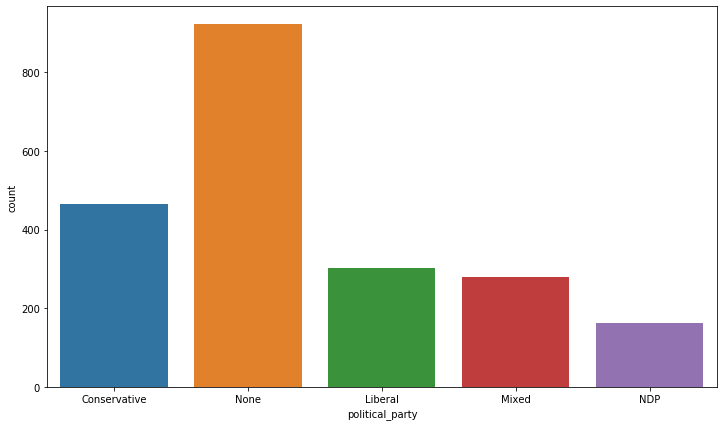

In [18]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy)

In [19]:
can_ele_2019_copy.groupby('political_party')['political_party'].count()

political_party
Conservative    466
Liberal         303
Mixed           280
NDP             162
None            922
Name: political_party, dtype: int64

**We can infer that most of the tweets are unclassified, then further on we have most count for conservative, liberal and NDP**

In [20]:
mixed_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive') & (can_ele_2019_copy['political_party']=='Mixed')]['political_party'].count()
mixed_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative') & (can_ele_2019_copy['political_party']=='Mixed')]['political_party'].count()

none_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive') & (can_ele_2019_copy['political_party']=='None')]['political_party'].count()
none_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative') & (can_ele_2019_copy['political_party']=='None')]['political_party'].count()

lpc_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive') & (can_ele_2019_copy['political_party']=='Liberal')]['political_party'].count()
lpc_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative') & (can_ele_2019_copy['political_party']=='Liberal')]['political_party'].count()

cpc_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive') & (can_ele_2019_copy['political_party']=='Conservative')]['political_party'].count()
cpc_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative') & (can_ele_2019_copy['political_party']=='Conservative')]['political_party'].count()

ndp_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive') & (can_ele_2019_copy['political_party']=='NDP')]['political_party'].count()
ndp_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative') & (can_ele_2019_copy['political_party']=='NDP')]['political_party'].count()

total_neg = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='negative')]['political_party'].count()
total_pos = can_ele_2019_copy[(can_ele_2019_copy['sentiment']=='positive')]['political_party'].count()

In [21]:
print ("% of Positive tweets for Each party out of the their respective total tweets:")
print ("Liberal: %0.2f, Conservative: %0.2f, NDP: %0.2f" % ((lpc_pos/(lpc_pos+lpc_neg)), (cpc_pos/(cpc_pos+cpc_neg)), (ndp_pos/(ndp_pos+ndp_neg))))

print ("\n% of Negative tweets for Each party out of the their respective total tweets:")
print ("Liberal: %0.2f, Conservative: %0.2f, NDP: %0.2f" % ((lpc_neg/(lpc_pos+lpc_neg)), (cpc_neg/(cpc_pos+cpc_neg)), (ndp_neg/(ndp_pos+ndp_neg))))

print ("\nRatio of Pos-vs-Neg in Mixed Tweets: %0.2f" % (mixed_pos/mixed_neg))

% of Positive tweets for Each party out of the their respective total tweets:
Liberal: 0.47, Conservative: 0.30, NDP: 0.71

% of Negative tweets for Each party out of the their respective total tweets:
Liberal: 0.53, Conservative: 0.70, NDP: 0.29

Ratio of Pos-vs-Neg in Mixed Tweets: 0.76


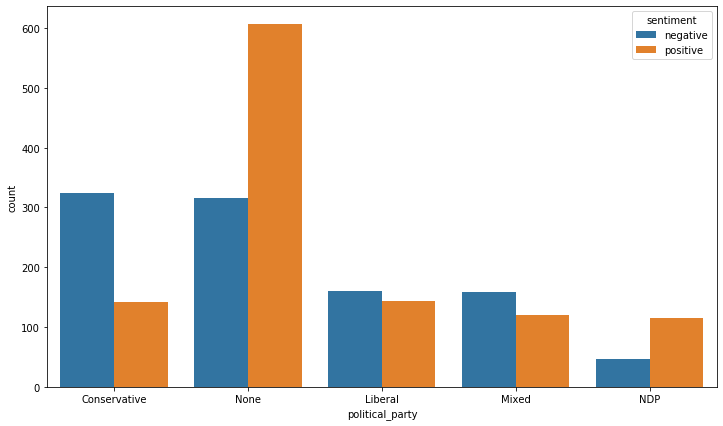

In [22]:
## Further distributing based on negative and positive sentiments

plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy, hue='sentiment')

Some Inferences:
    
 - Greater Proportion of the sentiment is positive for unclassified tweets
 - Conservative party has the most negative tweets
 - NDP party has the best positive to negative tweet ratio
 - Liberal party has almost equal number of negative and positive tweets
 
### Let's plot wordclouds to find out which words are dominant in the cleaned dataset

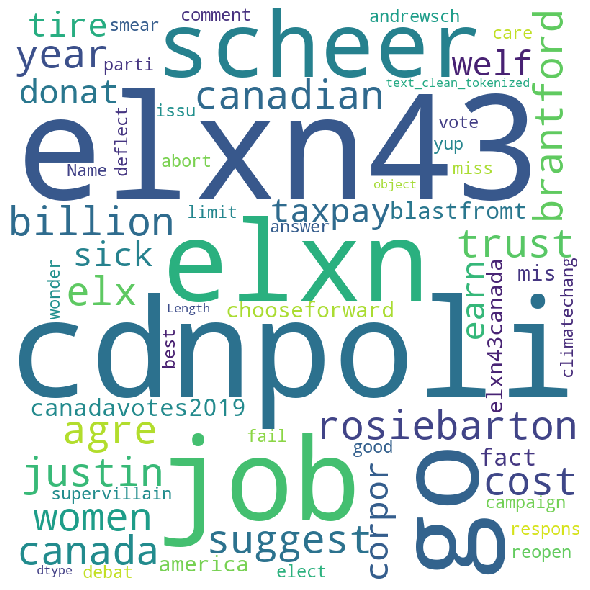

In [23]:
## WordCloud for NEGATIVE tweets in Elections Dataset

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(can_ele_2019_copy[can_ele_2019_copy['sentiment']=='negative']['text_clean_tokenized']))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Words such as 'andrewsch', 'justintrudeau' appear most frequently in NEGATIVE tweets in Elections Dataset**

**This could suggest that most of the public's negativity is directed towards the two major political parties since these two parties (Conservative, Liberal) have been in power the most in Canada**

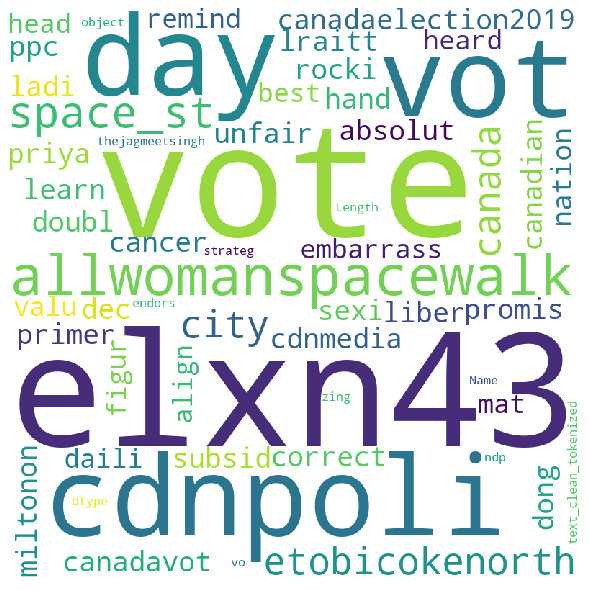

In [24]:
## WordCloud for POSITIVE tweets in Elections Dataset

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(can_ele_2019_copy[can_ele_2019_copy['sentiment']=='positive']['text_clean_tokenized']))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Apart from the generic election words such as 'elect', 'vote', etc. we find words such as 'conserv', 'ford', 'justintrudeau' appearing most prominently in POSITIVE tweets in Elections Dataset**

**There seems to be a stronger positive sentiment appearing towards the Liberal party as 'ford' and 'justintrudeau' is found in the majority of the positive tweets**

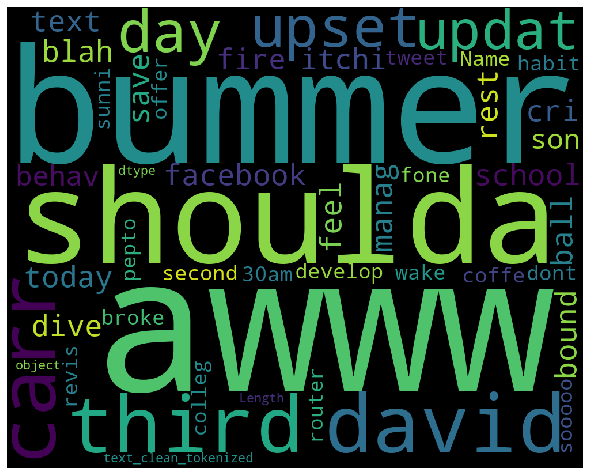

In [25]:
## WordCloud for NEGATIVE tweets in General Dataset

wordcloud = WordCloud(width = 1000, height = 800, background_color ='black', min_font_size = 10).generate(str(tw_df_copy[tw_df_copy['class']==0]['text_clean_tokenized']))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Words such as 'watch', 'rain' appear most in NEGATIVE tweets in General Dataset. We don't see many nouns/pronouns appearing in the wordcloud. Most Verbs have been associated as Negative words and they are dominant in the negative tweets**

**The word 'go' is found prominently in negative tweets here**

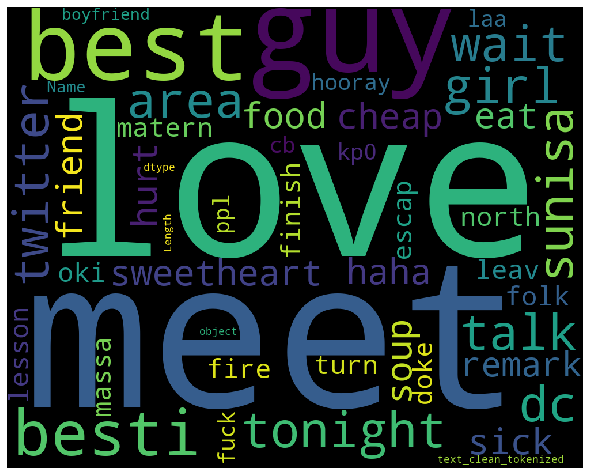

In [26]:
## WordCloud for POSITIVE tweets in General Dataset

wordcloud = WordCloud(width = 1000, height = 800, background_color ='black', min_font_size = 10).generate(str(tw_df_copy[tw_df_copy['class']==4]['text_clean_tokenized']))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Words such as 'love', 'tonight' appear most in POSITIVE tweets in General Dataset which can be expected. Apart from the word 'twitter', we don't see many nouns/pronouns appearing in the wordcloud, same as in the case of Negative Tweets WordCloud**

**The word 'go' appears in positive tweets as well; though it is found fewer times than in negative tweets. This could suggest that majority of the public associate the word 'go' in a negative tweet**

# Part C: Model Preparation

## 1. Computing Bag of Words (Word Frequency) and TF-IDF on General Tweets Dataset

#### Bag of Words counts the frequency of words in a document. The output of the bag of words model is a frequency vector

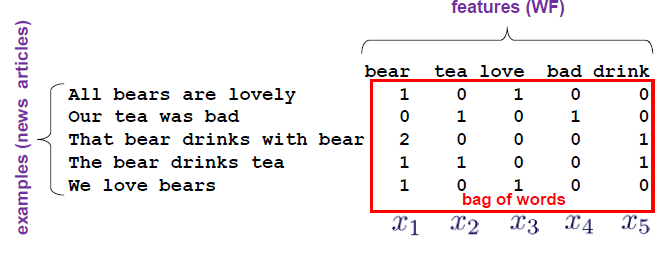

Source: From Course Slides

In [27]:
## Bag of Words on General Tweets

vectorizer_WF_gen = CountVectorizer(max_features=1000)  # Choosing max no of features as 1000 to save computational time (can remove the argument to get better accuracy)
array_WF_gen = vectorizer_WF_gen.fit_transform(tw_df_copy['text_clean_tokenized'])

# print(vectorizer_WF_gen.get_feature_names())
# print(array_WF_gen)

#### TF-IDF creates a set of its own vocabulary from the entire set of documents. It is short for “term frequency - inverse document frequency”

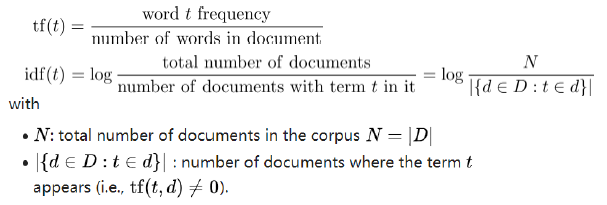

#### In this way, the method addresses the fact that all words should not be weighted equally. It weighs by indicating the words that are most unique to the document, and best used to characterize it.

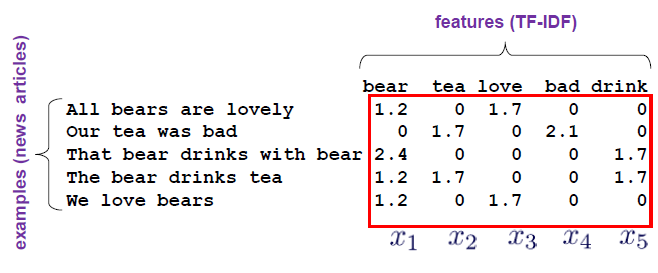

Source: From Course Slides

In [28]:
## TF-IDF on General Tweets

vectorizer_TFIDF_gen = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=1000) # Choosing max no of features as 1000 to save computational time (can remove the argument to get better accuracy)
array_TFIDF_gen = vectorizer_TFIDF_gen.fit_transform(tw_df_copy['text_clean_tokenized'])

# print( vectorizer_TFIDF_gen.get_feature_names() )
# print( array_TFIDF_gen )

In [29]:
## Assigning target variable here

y = tw_df_copy['class']

## 2. Implementing Algorithms - (Logistic Regression, KNN, Decision Trees, Random Forest, Naive Bayes, Support Vector Machines and XGBoost Classifier) on both sets of features

### a) Naive-Bayes

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c). Look at the equation below:

![](https://www.analyticsvidhya.com/wp-content/uploads/2015/09/Bayes_rule-300x172.png)

Above,

- P(c|x) is the posterior probability of class (c, target) given predictor (x, attributes).
- P(c) is the prior probability of class.
- P(x|c) is the likelihood which is the probability of predictor given class.
- P(x) is the prior probability of predictor.

Pros:

- It is easy and fast to predict class of test data set. It also perform well in multi class prediction
- When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
- It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).

Cons:

- If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
- On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
- Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.

Source: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

In [30]:
def naive_bayes_multinomialNB(x,y,split_ratio=0.3):
    
    '''Function for modeling based on Naive-Bayes MultinomialNB Classifier'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    X_train = X_train.toarray()
    X_test = X_test.toarray()
    
    model_nbg = MultinomialNB()
    model_nbg.fit(X_train,y_train)
    
    predictions = model_nbg.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the Naive-Bayes MultinomialNB Classifier model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))    
    
    return score

In [31]:
nb_bow = naive_bayes_multinomialNB(array_WF_gen,y)
nb_tfidf = naive_bayes_multinomialNB(array_TFIDF_gen,y)

The accuracy of the Naive-Bayes MultinomialNB Classifier model is:  71.09
              precision    recall  f1-score   support

           0       0.74      0.66      0.69     30063
           4       0.69      0.77      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.71      0.71      0.71     60000
weighted avg       0.71      0.71      0.71     60000

[[19705 10358]
 [ 6988 22949]]
The accuracy of the Naive-Bayes MultinomialNB Classifier model is:  70.87666666666667
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     30063
           4       0.69      0.77      0.72     29937

    accuracy                           0.71     60000
   macro avg       0.71      0.71      0.71     60000
weighted avg       0.71      0.71      0.71     60000

[[19565 10498]
 [ 6976 22961]]


### b) Logistic Regression

Logistic regression is a useful regression method for solving the binary classification problem. Another category of classification is Multinomial classification, which handles the issues where multiple classes are present in the target variable

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1534281070/linear_vs_logistic_regression_edxw03.png)

Sigmoid Function

The sigmoid function, also called logistic function gives an ‘S’ shaped curve that can take any real-valued number and map it into a value between 0 and 1. If the curve goes to positive infinity, y predicted will become 1, and if the curve goes to negative infinity, y predicted will become 0. If the output of the sigmoid function is more than 0.5, we can classify the outcome as 1 or YES, and if it is less than 0.5, we can classify it as 0 or NO.

Pros:

- Convenient probability scores for observations
- Efficient implementations available across tools
- Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent
- Wide spread industry comfort for logistic regression solutions

Cons:

- Doesn’t perform well when feature space is too large
- Doesn’t handle large number of categorical features/variables well
- Relies on transformations for non-linear features
- Relies on entire data

Source: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

In [32]:
def logreg(x,y,split_ratio=0.3):
    
    '''Function for modeling based on Logistic Regression'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_lg = LogisticRegression()
    model_lg.fit(X_train,y_train)
    
    predictions = model_lg.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the Log Reg model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))
    
    predictions_all = model_lg.predict(x)
    
    return model_lg, predictions_all, score

In [33]:
_, _, logreg_bow = logreg(array_WF_gen,y)
_, _, logreg_tfidf = logreg(array_TFIDF_gen,y)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model is:  71.15
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     30063
           4       0.68      0.78      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19218 10845]
 [ 6465 23472]]
The accuracy of the Log Reg model is:  71.14
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     30063
           4       0.68      0.78      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19214 10849]
 [ 6467 23470]]


### c) K-Nearest Neighbors

KNN is a non-parametric, lazy learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point.

When we say a technique is non-parametric , it means that it does not make any assumptions on the underlying data distribution. In other words, the model structure is determined from the data.

It does not use the training data points to do any generalization. In other words, there is no explicit training phase or it is very minimal. This also means that the training phase is pretty fast. Lack of generalization means that KNN keeps all the training data. To be more exact, all (or most) the training data is needed during the testing phase.

![](https://miro.medium.com/max/650/0*Sk18h9op6uK9EpT8.)

Pros:

- No assumptions about data — useful, for example, for nonlinear data
- Simple algorithm — to explain and understand/interpret
- High accuracy (relatively) — it is pretty high but not competitive in comparison to better supervised learning models
- Versatile — useful for classification or regression

Cons:

- Computationally expensive — because the algorithm stores all of the training data
- High memory requirement
- Stores all (or almost all) of the training data
- Prediction stage might be slow (with big N)
- Sensitive to irrelevant features and the scale of the data

Source: https://blog.usejournal.com/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7

In [34]:
def knn(x,y,split_ratio=0.3,neighbors=5):
    
    '''Function for modeling based on K-Nearest Neighbors'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_knn =  KNeighborsClassifier(n_neighbors=neighbors)
    model_knn.fit(X_train,y_train)
    
    predictions = model_knn.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the KNN model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))
    
    return score

In [35]:
knn_bow = knn(array_WF_gen,y)
knn_tfidf =  knn(array_TFIDF_gen,y)

The accuracy of the KNN model is:  65.42666666666666
              precision    recall  f1-score   support

           0       0.67      0.60      0.63     30063
           4       0.64      0.71      0.67     29937

    accuracy                           0.65     60000
   macro avg       0.66      0.65      0.65     60000
weighted avg       0.66      0.65      0.65     60000

[[17994 12069]
 [ 8675 21262]]
The accuracy of the KNN model is:  63.81666666666666
              precision    recall  f1-score   support

           0       0.66      0.57      0.61     30063
           4       0.62      0.70      0.66     29937

    accuracy                           0.64     60000
   macro avg       0.64      0.64      0.64     60000
weighted avg       0.64      0.64      0.64     60000

[[17263 12800]
 [ 8910 21027]]


### d) Decision Trees Classifier

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Simply put, a decision tree uses a tree-like data structure (typically, a binary tree) to make a model of the data (creating a sense of the data provided) using a bunch of if-else conditions at every node of the tree. It can be used for both classification and regression analysis.

Greedy nature of Decision Trees:

It should be clear that decision stumps are a fairly simple class of models that use only 1 feature at a time and hence, not very accurate for most tasks. A decision tree, on the other hand, considers a lot of features and allows a sequence of split based on these features. It is important to note that they are a very general class of models and can attain high accuracies but the task of finding the optimal decision tree is not feasible computationally and therefore, we use what is called a greedy approach to choose our decision tree.

Advantages:

- Easy to understand - Decision trees and the underlying principle that they work on are easy to interpret and understand as compared to other complex machine learning algorithms.
- Fast to learn - Decision trees are relatively quite fast to learn as you will see when you learn about other complex algorithms.

Disadvantages:

- Difficult to find an optimal set of rules - As we have already discussed, getting an optimal set of rules is hard and it is computationally inefficient to find such a set of rules and we have to use a greedy approach instead.
- Greedy splitting not accurate - This may require building very deep trees which might not be a good idea.

Source: https://adityashrm21.github.io/Decision-Trees/

In [36]:
def decision_tree(x,y,split_ratio=0.3):
    
    '''Function for modeling based on Decision Tree Classifier'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_dtc =  DecisionTreeClassifier(random_state=1)
    model_dtc.fit(X_train,y_train)
    
    predictions = model_dtc.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the Decision Tree Classifier model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))
    
    return score

In [37]:
dt_bow = decision_tree(array_WF_gen,y)
dt_tfidf = decision_tree(array_TFIDF_gen,y)

The accuracy of the Decision Tree Classifier model is:  65.46499999999999
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     30063
           4       0.65      0.67      0.66     29937

    accuracy                           0.65     60000
   macro avg       0.65      0.65      0.65     60000
weighted avg       0.65      0.65      0.65     60000

[[19228 10835]
 [ 9886 20051]]
The accuracy of the Decision Tree Classifier model is:  65.46166666666666
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     30063
           4       0.65      0.67      0.66     29937

    accuracy                           0.65     60000
   macro avg       0.65      0.65      0.65     60000
weighted avg       0.65      0.65      0.65     60000

[[19228 10835]
 [ 9888 20049]]


### e) Random Forests Classifier

Random forest is just an improvement over the top of the decision tree algorithm. The core idea behind Random Forest is to generate multiple small decision trees from random subsets of the data (hence the name “Random Forest”).
Each of the decision tree gives a biased classifier (as it only considers a subset of the data). They each capture different trends in the data. This ensemble of trees is like a team of experts each with a little knowledge over the overall subject but thourough in their area of expertise.

Now, in case of classification the majority vote is considered to classify a class. In analogy with experts, it is like asking the same multiple choice question to each expert and taking the answer as the one that most no. of experts vote as correct. In case of Regression, we can use the avg. of all trees as our prediction.In addition to this, we can also weight some more decisive trees high relative to others by testing on the validation data.

![](https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/rf.png)

The advantages of random forests include:

- The predictive performance can compete with the best supervised learning algorithms
- They provide a reliable feature importance estimate
- They offer efficient estimates of the test error without incurring the cost of repeated model training associated with cross-validation

On the other hand, random forests also have a few disadvantages:

- An ensemble model is inherently less interpretable than an individual decision tree
- Training a large number of deep trees can have high computational costs (but can be parallelized) and use a lot of memory
- Predictions are slower, which may create challenges for applications

Sources: 
- https://www.oreilly.com/library/view/hands-on-machine-learning/9781789346411/e17de38e-421e-4577-afc3-efdd4e02a468.xhtml
- https://dimensionless.in/introduction-to-random-forest/

In [38]:
def ran_forest(x,y,split_ratio=0.3):
    
    '''Function for modeling based on Random Forest Classifier'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_rfc =  RandomForestClassifier()
    model_rfc.fit(X_train,y_train)
    
    predictions = model_rfc.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the Random Forest Classifier model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))    
    
    return score

In [39]:
rf_bow = ran_forest(array_WF_gen,y)
rf_tfidf = ran_forest(array_TFIDF_gen,y)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest Classifier model is:  67.72166666666666
              precision    recall  f1-score   support

           0       0.69      0.65      0.67     30063
           4       0.67      0.71      0.69     29937

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

[[19430 10633]
 [ 8734 21203]]


C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest Classifier model is:  67.88166666666666
              precision    recall  f1-score   support

           0       0.69      0.65      0.67     30063
           4       0.67      0.71      0.69     29937

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

[[19445 10618]
 [ 8653 21284]]


### f) XGBoost Classifier

XGBoost stands for Extreme Gradient Boosting. It is a supervised learning algorithm. It is a library for developing fast and high performance gradient boosting tree models. Parallel computation behind the scenes is what makes it this fast. It has been very popular in recent years due to its versatiltiy, scalability and efficiency.

XGBoost and Gradient Boosting Machines (GBMs) are both ensemble tree methods that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture.

Pros:

- Extremely fast (parallel computation).
- Highly efficient.
- Versatile (Can be used for classification, regression or ranking).
- Can be used to extract variable importance.
- Do not require feature engineering (missing values imputation, scaling and normalization)

Cons:

- Only work with numeric features.
- Leads to overfitting if hyperparameters are not tuned properly.

Sources:
- https://dimensionless.in/introduction-to-xgboost/
- https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

In [40]:
def xgb_classifier(x,y,split_ratio=0.3):
    
    '''Function for modeling based on XGBoost Classifier'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_xgb = XGBClassifier()
    model_xgb.fit(X_train,y_train)
    
    predictions = model_xgb.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the XGBoost Classifier model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))    
    
    return score

In [41]:
xgb_bow = xgb_classifier(array_WF_gen,y)
xgb_tfidf = xgb_classifier(array_TFIDF_gen,y)

The accuracy of the XGBoost Classifier model is:  65.61
              precision    recall  f1-score   support

           0       0.78      0.43      0.56     30063
           4       0.61      0.88      0.72     29937

    accuracy                           0.66     60000
   macro avg       0.70      0.66      0.64     60000
weighted avg       0.70      0.66      0.64     60000

[[13046 17017]
 [ 3617 26320]]
The accuracy of the XGBoost Classifier model is:  65.61
              precision    recall  f1-score   support

           0       0.78      0.43      0.56     30063
           4       0.61      0.88      0.72     29937

    accuracy                           0.66     60000
   macro avg       0.70      0.66      0.64     60000
weighted avg       0.70      0.66      0.64     60000

[[13046 17017]
 [ 3617 26320]]


To better understand the above tree-based algorithms, see below for a simple analogy to know about their evolution

Imagine that you are a hiring manager interviewing several candidates with excellent qualifications. Each step of the evolution of tree-based algorithms can be viewed as a version of the interview process.

- Decision Tree: Every hiring manager has a set of criteria such as education level, number of years of experience, interview performance. A decision tree is analogous to a hiring manager interviewing candidates based on his or her own criteria.
- Bagging: Now imagine instead of a single interviewer, now there is an interview panel where each interviewer has a vote. Bagging or bootstrap aggregating involves combining inputs from all interviewers for the final decision through a democratic voting process.
- Random Forest: It is a bagging-based algorithm with a key difference wherein only a subset of features is selected at random. In other words, every interviewer will only test the interviewee on certain randomly selected qualifications (e.g. a technical interview for testing programming skills and a behavioral interview for evaluating non-technical skills).
- Boosting: This is an alternative approach where each interviewer alters the evaluation criteria based on feedback from the previous interviewer. This ‘boosts’ the efficiency of the interview process by deploying a more dynamic evaluation process.
- Gradient Boosting: A special case of boosting where errors are minimized by gradient descent algorithm e.g. the strategy consulting firms leverage by using case interviews to weed out less qualified candidates.
- XGBoost: Think of XGBoost as gradient boosting on ‘steroids’ (well it is called ‘Extreme Gradient Boosting’ for a reason!). It is a perfect combination of software and hardware optimization techniques to yield superior results using less computing resources in the shortest amount of time.

Source: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

### g) Linear SVC Classifier

Support vector machines so called as SVM is a supervised learning algorithm which can be used for classification and regression problems as support vector classification (SVC) and support vector regression (SVR)

SVM is based on the idea of finding a hyperplane that best separates the features into different domains

The points closest to the hyperplane are called as the support vector points and the distance of the vectors from the hyperplane are called the margins.

![](https://miro.medium.com/max/410/0*luhI3gW7WnXfLnhA.jpg)

Pros:

- It is really effective in the higher dimension.
- Effective when the number of features are more than training examples.
- Best algorithm when classes are separable
- The hyperplane is affected by only the support vectors thus outliers have less impact.
- SVM is suited for extreme case binary classification.

Cons:

- For larger dataset, it requires a large amount of time to process.
- Does not perform well in case of overlapped classes.
- Selecting, appropriately hyperparameters of the SVM that will allow for sufficient generalization performance.
- Selecting the appropriate kernel function can be tricky.

Source: https://towardsdatascience.com/support-vector-machines-svm-c9ef22815589

In [42]:
def svm_classifier(x,y,split_ratio=0.3):
    
    '''Function for modeling based on SVM (Support Vector Machines) Classifier'''
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
    
    model_svm = LinearSVC(random_state=0, max_iter=30000)
    model_svm.fit(X_train,y_train)
    
    predictions = model_svm.predict(X_test)
    
    score = accuracy_score(y_test,predictions)

    print ("The accuracy of the SVM Classifier model is: ", score*100)
    
    print(classification_report(y_test,predictions))
    
    print (confusion_matrix(y_test,predictions))    
    
    return score

In [43]:
svm_bow = svm_classifier(array_WF_gen,y)
svm_tfidf = svm_classifier(array_TFIDF_gen,y)

The accuracy of the SVM Classifier model is:  71.1
              precision    recall  f1-score   support

           0       0.75      0.63      0.69     30063
           4       0.68      0.79      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19005 11058]
 [ 6282 23655]]
The accuracy of the SVM Classifier model is:  71.09833333333333
              precision    recall  f1-score   support

           0       0.75      0.63      0.69     30063
           4       0.68      0.79      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19003 11060]
 [ 6281 23656]]


C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Plotting the accuracies for each model against each type of feature

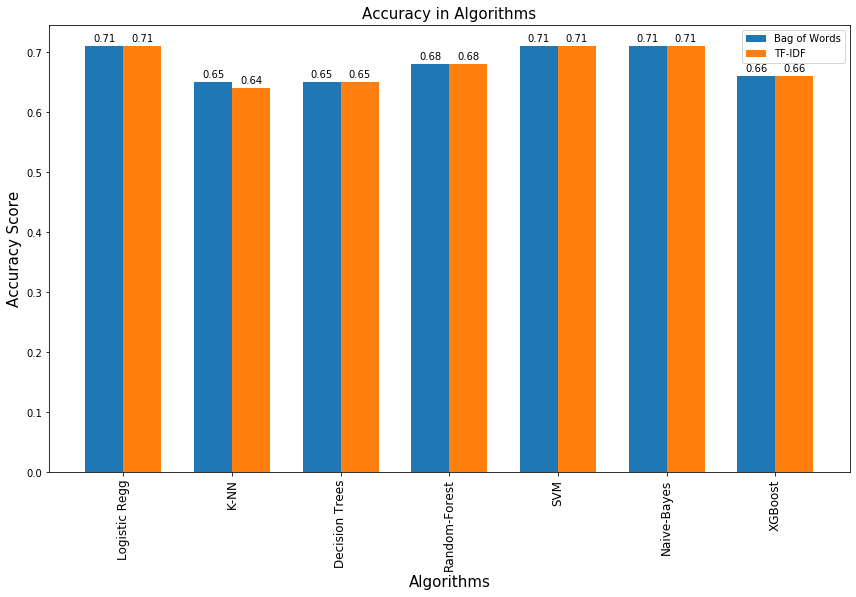

In [44]:
labels = ['Logistic Regg', 'K-NN', 'Decision Trees', 'Random-Forest', 'SVM', 'Naive-Bayes', 'XGBoost']
y_bow = [round(logreg_bow,2), round(knn_bow,2), round(dt_bow,2), round(rf_bow,2), round(svm_bow,2), round(nb_bow,2), round(xgb_bow,2)]
y_tfidf = [round(logreg_tfidf,2), round(knn_tfidf,2), round(dt_tfidf,2), round(rf_tfidf,2), round(svm_tfidf,2), round(nb_tfidf,2), round(xgb_tfidf,2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,7))
rects1 = ax.bar(x - width/2, y_bow, width, label='Bag of Words')
rects2 = ax.bar(x + width/2, y_tfidf, width, label='TF-IDF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Score', fontsize = 15)
ax.set_title('Accuracy in Algorithms', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xlabel('Algorithms', fontsize = 15)
plt.xticks(rotation = 90,  fontsize = 12)
plt.show()

**As we can see, the accuracy achieved by Logistic Regression, Naive-Bayes and SVM model is highest on Bag of Words and TF-IDF features. However, as SVM is computationally expensive and for the sake of simplicity, we will go forward with the Logistic Regression model with Bag of Words feature type. So now we apply the Logistic Regression Model on Elections Dataset**

# Part D: Model Implementation

## 1. Applying Bag of Words on the Elections Dataset below

In [45]:
array_WF_ele = vectorizer_WF_gen.transform(can_ele_2019_copy['text_clean_tokenized'])
# Choosing the same vectorizer as taken in general tweets dataset for bag of words

# print(vectorizer_WF_ele.get_feature_names())
# print(array_WF_ele)

In [46]:
## Encoding the target based on classes of general dataset
can_ele_2019_copy['class'] = can_ele_2019_copy['sentiment'].map({'positive':4,'negative':0})

## Initializing the target variable
y_ele=can_ele_2019_copy['class']

## 2. Implementing the best model on Elections dataset

In [47]:
def logreg_ele(x1,y1,x2,y2,split_ratio=0.3):
    
    ''' Function to implement the best model from general dataset on election dataset'''
    
    X_train, X_test, y_train, y_test = train_test_split(x1,y1,test_size=0.3,random_state=1)
    
    model = LogisticRegression()
    model.fit(X_train,y_train)
    
    predictions = model.predict(x2)
    
    score = accuracy_score(y2,predictions)

    print ("The accuracy of the Log Reg model of Canadian Elections Tweets is: ", score*100)
    
    print(classification_report(y2,predictions))
    
    print (confusion_matrix(y2,predictions))
    
    return predictions, score

In [48]:
predictions, election_score = logreg_ele(array_WF_gen, y, array_WF_ele, y_ele)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model of Canadian Elections Tweets is:  60.618846694796055
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      1006
           4       0.60      0.74      0.66      1127

    accuracy                           0.61      2133
   macro avg       0.61      0.60      0.59      2133
weighted avg       0.61      0.61      0.60      2133

[[461 545]
 [295 832]]


### We get an accuracy of **60.61%** from the best model applied to the elections dataset. This means about half of the predictions were correctly predicted and half were incorrect.

### Let's see how the predictions were for each of the parties

In [49]:
## Below model creates a column that states whether the prediction made was correct or incorrect

can_ele_2019_copy['predictions'] = predictions
can_ele_2019_copy['prediction_sentiment'] = can_ele_2019_copy['predictions'].map({0:'negative',4:'positive'})
can_ele_2019_copy['sentiment_vs_prediction'] = '0'

for i in range(len(can_ele_2019_copy['sentiment_vs_prediction'])):
    if can_ele_2019_copy['class'][i]==can_ele_2019_copy['predictions'][i]:
        can_ele_2019_copy['sentiment_vs_prediction'][i]='truly_predicted'
    else:
        can_ele_2019_copy['sentiment_vs_prediction'][i]='falsely_predicted'

can_ele_2019_copy  # Take a look at the last column i.e. 'sentiment_vs_prediction'

C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party,class,predictions,prediction_sentiment,sentiment_vs_prediction
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,Conservative,0,4,positive,falsely_predicted
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[""#allwomanspacewalk it's real!@space_station ...",allwomanspacewalk space_st etobicokenorth city...,None,4,4,positive,truly_predicted
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,Liberal,0,0,negative,truly_predicted
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[""#canada #canadaelection2019 #canadavotes #el...",canada canadaelection2019 canadavot elxn43 dec...,None,4,4,positive,truly_predicted
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,Liberal,0,0,negative,truly_predicted
...,...,...,...,...,...,...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,Conservative,0,4,positive,falsely_predicted
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,Conservative,0,0,negative,truly_predicted
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,['your daily reminder:@thejagmeetsingh endorse...,daili remind thejagmeetsingh endors strateg vo...,Mixed,4,4,positive,truly_predicted
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,['yup...not going to reopen the abortion debat...,yup go reopen abort debat elxn43 scheer scheer...,Conservative,0,4,positive,falsely_predicted


**Plotting the predictions of each party below**

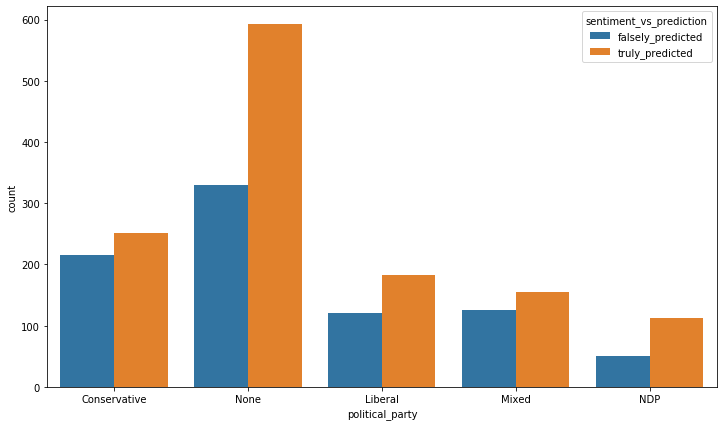

In [50]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy, hue='sentiment_vs_prediction')

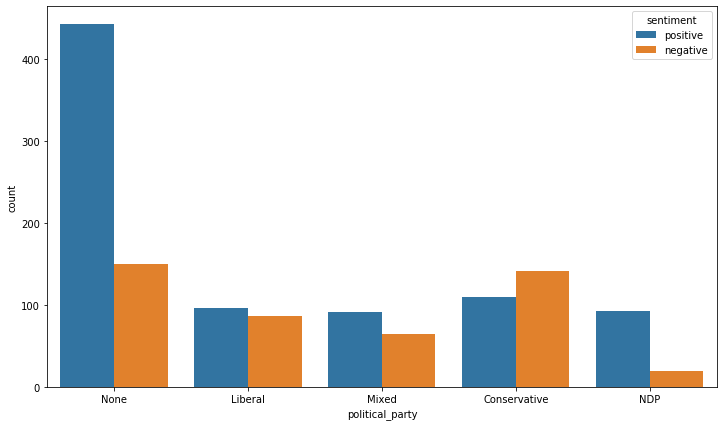

In [51]:
## Looking at the count of positive and negative tweets in correct predictions

plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy[can_ele_2019_copy['sentiment_vs_prediction']=='truly_predicted'], hue='sentiment')

**As we can see, the Conservative Party's negative predictions outnumber the positive predictions. The Liberal party's positive and negative predicitons count is almost the same which could mean that half of the public has positive viewpoint and other half as negative viewpoint on the Liberal party. The count of negative tweets for the NDP party is low and their response is more positive which can mean that in future, it may emerge as significant running party**

**The total count of positive and negative tweets in the Mixed and None class is more positive (positive surpassing negative). This shows that the part of public which is neutral has good/positive viewpoint of the current running government i.e. Liberal Party**

**Fact: Liberal Party won 2019 Federal Elections**

**This shows that NLP analytics of tweets can act as an indicator of the elections outcome. Tweets play the role of voice of the general public. So, it can be useful for political parties to do NLP of tweets to know where they stand and what they should change to turn the election result towards them**

## 3. Fitting three models on the column 'negative_reason' of all negative tweets

In [52]:
## Splitting the dataset to consist only negative tweets of election dataset

can_ele_neg_split = can_ele_2019_copy[can_ele_2019_copy['sentiment']=='negative']
can_ele_neg_split

,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party,class,predictions,prediction_sentiment,sentiment_vs_prediction
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,Conservative,0,4,positive,falsely_predicted
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,Liberal,0,0,negative,truly_predicted
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,Liberal,0,0,negative,truly_predicted
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[""#canadavotes2019 #elxn43 #cdnpoli - facts - ...",canadavotes2019 elxn43 cdnpoli fact blastfromt...,Conservative,0,4,positive,falsely_predicted
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[""#chooseforward #cdnpoli #elxn43canada, don't...",chooseforward cdnpoli elxn43canada america mis...,None,0,4,positive,falsely_predicted
...,...,...,...,...,...,...,...,...,...,...
2125,negative,Others,b'You can\xe2\x80\x99t be a supervillain of an...,['you can’t be a supervillain of an election i...,supervillain elect fail job elxn43,None,0,0,negative,truly_predicted
2126,negative,Climate Problem,b'You care about limiting #ClimateChange and a...,['you care about limiting #climatechange and a...,care limit climatechang wonder parti vote elxn...,None,0,4,positive,falsely_predicted
2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,Conservative,0,4,positive,falsely_predicted
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,Conservative,0,0,negative,truly_predicted


In [53]:
## Finding the count of each negative reason

can_ele_neg_split.groupby(['negative_reason'])['negative_reason'].count()

negative_reason
Climate Problem                         41
Economy                                 51
Healthcare                               5
Healthcare and Marijuana                 4
Others                                 364
Privilege                               12
Scandal                                270
Separation                              16
Tell lies                              198
Women Reproductive right and Racism     45
Name: negative_reason, dtype: int64

### Let's combine some classes together so we have enough count for each class to model upon

Reasons Combined:

1. Economy + Privilege = Economy 
(both Economy and Privilege Tweets talk about the economy (and policies) of the country)
2. Healthcare + Healthcare and Marijuana + Women Reproductive right and Racism = Healthcare 
(All of these classes come under a single umbrella of Healthcare)
3. Tell Lies + Separation = Manipulative
(these classes represent manipulative tweets, so renames them as Manipulative)

In [54]:
## Combining the classes as per the reasons given above

can_ele_neg_split=can_ele_neg_split.reset_index()
can_ele_neg_split['grouped_reasons'] = '0'

for i in range(len(can_ele_neg_split['negative_reason'])):
    if (can_ele_neg_split['negative_reason'][i]=='Climate Problem'):
        can_ele_neg_split['grouped_reasons'][i] = 'Climate Problem'
    elif (can_ele_neg_split['negative_reason'][i]=='Economy') | (can_ele_neg_split['negative_reason'][i]=='Privilege') :
        can_ele_neg_split['grouped_reasons'][i] = 'Economy'
    elif (can_ele_neg_split['negative_reason'][i]=='Healthcare') | (can_ele_neg_split['negative_reason'][i]=='Healthcare and Marijuana') | (can_ele_neg_split['negative_reason'][i]=='Women Reproductive right and Racism') :
        can_ele_neg_split['grouped_reasons'][i] = 'Healthcare'
    elif can_ele_neg_split['negative_reason'][i]=='Scandal' :
        can_ele_neg_split['grouped_reasons'][i] = 'Scandalous'
    elif (can_ele_neg_split['negative_reason'][i]=='Tell lies') | (can_ele_neg_split['negative_reason'][i]=='Separation') :
        can_ele_neg_split['grouped_reasons'][i] = 'Manipulative'
    elif can_ele_neg_split['negative_reason'][i]=='Others':
        can_ele_neg_split['grouped_reasons'][i] = 'Others'

can_ele_neg_split        

C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anmol\Anaconda3\

,index,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party,class,predictions,prediction_sentiment,sentiment_vs_prediction,grouped_reasons
0,0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,Conservative,0,4,positive,falsely_predicted,Healthcare
1,2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,Liberal,0,0,negative,truly_predicted,Economy
2,4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,Liberal,0,0,negative,truly_predicted,Economy
3,5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[""#canadavotes2019 #elxn43 #cdnpoli - facts - ...",canadavotes2019 elxn43 cdnpoli fact blastfromt...,Conservative,0,4,positive,falsely_predicted,Others
4,8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[""#chooseforward #cdnpoli #elxn43canada, don't...",chooseforward cdnpoli elxn43canada america mis...,None,0,4,positive,falsely_predicted,Others
...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2125,negative,Others,b'You can\xe2\x80\x99t be a supervillain of an...,['you can’t be a supervillain of an election i...,supervillain elect fail job elxn43,None,0,0,negative,truly_predicted,Others
1002,2126,negative,Climate Problem,b'You care about limiting #ClimateChange and a...,['you care about limiting #climatechange and a...,care limit climatechang wonder parti vote elxn...,None,0,4,positive,falsely_predicted,Climate Problem
1003,2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,Conservative,0,4,positive,falsely_predicted,Scandalous
1004,2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,Conservative,0,0,negative,truly_predicted,Scandalous


In [55]:
## Printing count of reasons after grouping

can_ele_neg_split.groupby(['grouped_reasons'])['grouped_reasons'].count()

grouped_reasons
Climate Problem     41
Economy             63
Healthcare          54
Manipulative       214
Others             364
Scandalous         270
Name: grouped_reasons, dtype: int64

In [56]:
## Implementing Bag of Words on the split dataset

vectorizer_WF_ele_neg = CountVectorizer()
array_WF_ele_neg = vectorizer_WF_ele_neg.fit_transform(can_ele_neg_split['text_clean_tokenized'])

# print(vectorizer_WF_ele_neg.get_feature_names())
# print(array_WF_ele_neg)

In [57]:
## Setting the target variable as the classes of reasons

y_ele_neg=can_ele_neg_split['grouped_reasons']

### Implementing the Logistic Regg, Decision Tree and Random Forest Classifier models

In [58]:
_, neg_predictions, _ = logreg(array_WF_ele_neg,y_ele_neg)
decision_tree(array_WF_ele_neg,y_ele_neg)
ran_forest(array_WF_ele_neg,y_ele_neg)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy of the Log Reg model is:  59.27152317880795
                 precision    recall  f1-score   support

Climate Problem       1.00      0.27      0.43        11
        Economy       0.60      0.16      0.25        19
     Healthcare       0.50      0.18      0.27        11
   Manipulative       0.62      0.55      0.58        64
         Others       0.55      0.81      0.65       114
     Scandalous       0.66      0.53      0.59        83

       accuracy                           0.59       302
      macro avg       0.66      0.42      0.46       302
   weighted avg       0.61      0.59      0.57       302

[[ 3  1  0  2  4  1]
 [ 0  3  0  4 10  2]
 [ 0  0  2  3  5  1]
 [ 0  1  0 35 20  8]
 [ 0  0  1 10 92 11]
 [ 0  0  1  2 36 44]]
The accuracy of the Decision Tree Classifier model is:  54.966887417218544
                 precision    recall  f1-score   support

Climate Problem       0.67      0.36      0.47        11
        Economy       0.33      0.21      0.26       

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5364238410596026

In [59]:
can_ele_neg_split['negative_reason_predictions'] = neg_predictions
can_ele_neg_split

,index,sentiment,negative_reason,text,text_clean,text_clean_tokenized,political_party,class,predictions,prediction_sentiment,sentiment_vs_prediction,grouped_reasons,negative_reason_predictions
0,0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[""@rosiebarton so instead of your suggestion, ...",rosiebarton suggest agre canadian women trust ...,Conservative,0,4,positive,falsely_predicted,Healthcare,Healthcare
1,2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[""#brantford it's going to cost you $94 billio...",brantford go cost 94 billion 4 year justin elx...,Liberal,0,0,negative,truly_predicted,Economy,Economy
2,4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[""#canada #taxpayers are sick & tired of havin...",canada taxpay sick tire earn donat corpor welf...,Liberal,0,0,negative,truly_predicted,Economy,Others
3,5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[""#canadavotes2019 #elxn43 #cdnpoli - facts - ...",canadavotes2019 elxn43 cdnpoli fact blastfromt...,Conservative,0,4,positive,falsely_predicted,Others,Others
4,8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[""#chooseforward #cdnpoli #elxn43canada, don't...",chooseforward cdnpoli elxn43canada america mis...,None,0,4,positive,falsely_predicted,Others,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2125,negative,Others,b'You can\xe2\x80\x99t be a supervillain of an...,['you can’t be a supervillain of an election i...,supervillain elect fail job elxn43,None,0,0,negative,truly_predicted,Others,Others
1002,2126,negative,Climate Problem,b'You care about limiting #ClimateChange and a...,['you care about limiting #climatechange and a...,care limit climatechang wonder parti vote elxn...,None,0,4,positive,falsely_predicted,Climate Problem,Climate Problem
1003,2128,negative,Scandal,b'You know he was doing a good enough job smea...,['you know he was doing a good enough job smea...,good job smear campaign andrewsch cdnpoli elxn...,Conservative,0,4,positive,falsely_predicted,Scandalous,Scandalous
1004,2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,['you missed the comment. deflecting the issue...,miss comment deflect issu answer best respons ...,Conservative,0,0,negative,truly_predicted,Scandalous,Scandalous


### Best Accuracy achieved by Logistic Regression model (59.27%)

# Part E: Results

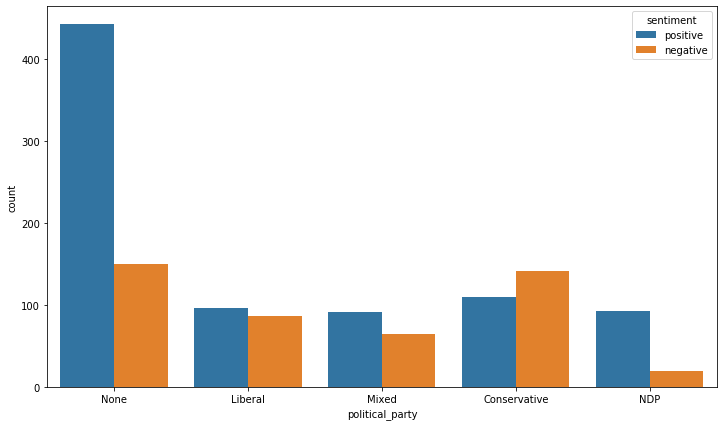

In [60]:
## Looking at the count of positive and negative tweets in correct predictions

plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy[can_ele_2019_copy['sentiment_vs_prediction']=='truly_predicted'], hue='sentiment')

### Q1 - Research Question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value.

**We found out through our NLP analysis of the Canadian Elections 2019 tweets, the Conservative party had an overall negative response while the Liberal and NDP had more positive responses. However, NDP being not so prominent in the current political landscape could not gather much votes. So, the outcome of the federal elections 2019 was that the Liberal party won.**

**Moreover, the total count of positive responses in Mixed and None categories surpass the negative responses which meant that the public was satisfied (not completely obviously) with the current government of Liberal party**

**The tweets by the public acted as an indicator to where the election was going. They can tell how the public views the political parties and it is their viewpoint which is reflected from votes. Thus, public tweets of 2019 portrayed/predicted what the Canadian Elections result would be.**

### Q2 - Describe the results of the analysis and discuss your interpretation of the results.

### Q3 - Explain how each party is viewed in the public eye based on the sentiment value.

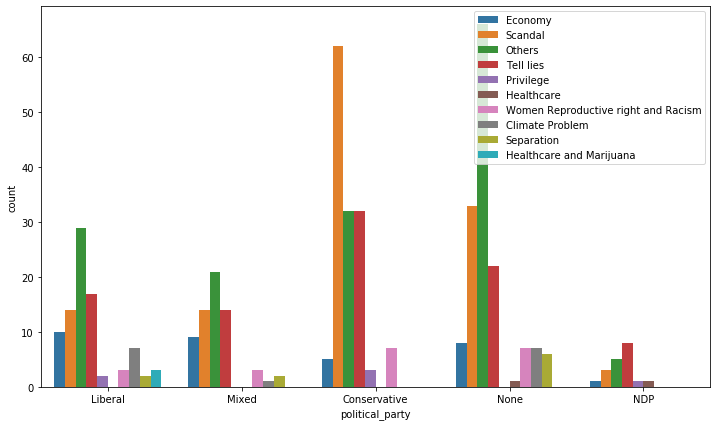

In [61]:
## Looking at the distribution of negative tweets in correct predictions

plt.figure(figsize=(12,7))
ax = sns.countplot(x="political_party", data=can_ele_2019_copy[(can_ele_2019_copy['sentiment_vs_prediction']=='truly_predicted') & (can_ele_2019_copy['sentiment']=='negative')], hue='negative_reason')
plt.legend(loc='upper right')

**This is substantiated from the above graph where most of the negative tweets of Conservative party are categorized as 'Scandal' or 'Tell Lies' whereas most of the negative tweets for the rest of the parties are in 'Others' category**

**It shows that public associated Conservative party with deceit, scandalous and lies in their tweets. The same can be said for Liberal party but it is not to the same degree/count as the Conservative party**

### Q4 - For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets.

**As we achieved an accuracy of only 59.27% with Logistic Regression (the highest amongst three models), this model may fail to predict the correct negative reasons. Let's see why**

In [62]:
## Let's take a look at the number of samples for each class

can_ele_neg_split.groupby(['grouped_reasons'])['grouped_reasons'].count()

grouped_reasons
Climate Problem     41
Economy             63
Healthcare          54
Manipulative       214
Others             364
Scandalous         270
Name: grouped_reasons, dtype: int64

**It can be inferred that the count is disproportionate as we have only about 50 samples for three classes and about 250 for the other three classes**

**Let's generate random samples and see how our model predicted**

In [63]:
## Generating 3 random samples
samples1=can_ele_neg_split.sample(3, random_state=110)

## Printing Actual reason vs Predicted reason
samples1[['grouped_reasons','negative_reason_predictions']]

,grouped_reasons,negative_reason_predictions
209,Manipulative,Manipulative
531,Climate Problem,Economy
604,Others,Others


In [64]:
## Printing the tweet for the incorrect prediction (index no. 531)
samples1.iloc[1,3]

"b'@PluginAlberta @XDeimos @twter_JohnM @GretaThunberg @theAESO @svenskakyrkan @jkenney Some Chinese Electric Cars Are \\xe2\\x80\\x98Simply Worthless\\xe2\\x80\\x99: Industry Body https://t.co/zjPnOWT9ak Imagine how many more coal plants they will have to build to power them. #ableg #abpoli #cdnpoli #elxn43'"

**Judging from the tweet, it is clear that the tweet is about 'Climate Problem'. However, our model predicts it as 'Economy' which is obviously incorrect. This could be due to the fact that we have less number of rows to model on either 'Climate Problem' or 'Economy**

**Let's generate another random sample**

In [65]:
## Generating 3 random samples
samples2=can_ele_neg_split.sample(3, random_state=330)

## Printing Actual reason vs Predicted reason
samples2[['grouped_reasons','negative_reason_predictions']]

,grouped_reasons,negative_reason_predictions
744,Scandalous,Scandalous
246,Scandalous,Scandalous
831,Manipulative,Others


In [66]:
## Printing the tweet for the incorrect prediction (index no. 467)
samples2.iloc[2,3]

"b'Our federal politicians, regardless of their stripes, have allowed all of #Canada to be hijacked by separatist extremists in #Quebec. #CanadaDeservesBetter #cdnpoli #canpoli #elxn43 #elxn2019 #canadavotes2019 #CanadaElection2019 #CDNvote2019'"

**Again judging from the tweet, it can be inferred that the tweet is about 'Manipulation' i.e. 'Separation'. However, our model predicts it as 'others' which is incorrect**

**Therefore, as we got few samples per class to build our model, we obtain low accuracy in our model**

### Q - For both models, suggest one way you can improve the accuracy of your models.

**Ways to improve accuracy**

1. Obtaining more samples to build the model upon (Strongly applicable in Second Model)
2. Tuning the hyper-parameters of the model
3. Not performing the removal of stop-words and stemming procedure as this will affect the model by reducing words and no of features subsequently to build the model
4. Increasing the number of max_features in CountVectorizer/TF-IDF Vectorizer to get more features to build model

## BONUS

### Trying Word-Embeddings and trying N-grams in CountVectorizer (Bag of Words) and TF-IDF Vectorizer

#### 1. Word-Embedding

**Word2Vec is a shallow, two-layer neural networks which is trained to reconstruct linguistic contexts of words.**

**It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.**

**Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.**

Source: https://israelg99.github.io/2017-03-23-Word2Vec-Explained/

In [67]:
size=100 # Defining the size of vector of each word (100x1 size vector in this case)

tokenized_sentences = [sentence.split() for sentence in corpus_clean_gen] # tokenizing each word from the general dataset corpus
model_word2vec = word2vec.Word2Vec(tokenized_sentences, size=size, min_count=1) # building word2vec model from tokenized words

In [68]:
def buildWordVector(text, size):
    
    """ Function to add and average out all vectorized words together from a particular tweet"""
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    if text == '':
        return vec
    else:
        text = text.split(' ')
        for word in text:
            vec += model_word2vec[word].reshape((1, size))
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [69]:
## Building an array of averaged out vectors of all tweets and storing it as an array
array_wordEmbedding = np.concatenate([buildWordVector(z, size) for z in corpus_clean_gen])

C:\Users\Anmol\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


**Running the model - Logistic Regression, Decision Tree and Random Forest on Embedded Features**

In [70]:
logreg(array_wordEmbedding,y), decision_tree(array_wordEmbedding,y), ran_forest(array_wordEmbedding,y)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model is:  66.31166666666667
              precision    recall  f1-score   support

           0       0.68      0.62      0.65     30063
           4       0.65      0.70      0.68     29937

    accuracy                           0.66     60000
   macro avg       0.66      0.66      0.66     60000
weighted avg       0.66      0.66      0.66     60000

[[18785 11278]
 [ 8935 21002]]
The accuracy of the Decision Tree Classifier model is:  59.24333333333334
              precision    recall  f1-score   support

           0       0.59      0.59      0.59     30063
           4       0.59      0.60      0.59     29937

    accuracy                           0.59     60000
   macro avg       0.59      0.59      0.59     60000
weighted avg       0.59      0.59      0.59     60000

[[17656 12407]
 [12047 17890]]


C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest Classifier model is:  62.74833333333333
              precision    recall  f1-score   support

           0       0.62      0.68      0.65     30063
           4       0.64      0.57      0.61     29937

    accuracy                           0.63     60000
   macro avg       0.63      0.63      0.63     60000
weighted avg       0.63      0.63      0.63     60000

[[20474  9589]
 [12762 17175]]


((LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  array([4, 0, 0, ..., 0, 0, 4], dtype=int64),
  0.6631166666666667),
 0.5924333333333334,
 0.6274833333333333)

### There is no improvement in accuracy from Word-Embedding. So, let's move forward with N-Grams

#### 2. N-Grams in Bag of Words and TF-IDF

Wikipedia defines an N-Gram as "A contiguous sequence of N items from a given sample of text or speech". Here an item can be a character, a word or a sentence and N can be any integer. When N is 2, we call the sequence a bigram. Similarly, a sequence of 3 items is called a trigram, and so on.

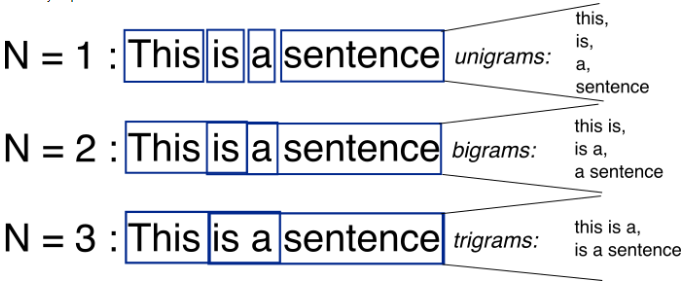

Source: https://stackoverflow.com/questions/18193253/what-exactly-is-an-n-gram

In [71]:
## Initializing with a trigram in TF-IDF
vectorizer_TFIDF_gen2 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=1000, ngram_range=(1,3))
array_TFIDF_gen2 = vectorizer_TFIDF_gen2.fit_transform(tw_df_copy['text_clean_tokenized'])

# print( vectorizer_TFIDF_gen.get_feature_names() )
# print( array_TFIDF_gen2 )

**Running the model - Logistic Regression, Decision Tree and Random Forest on Trigram TF-IDF**

In [72]:
logreg(array_TFIDF_gen2,y), decision_tree(array_TFIDF_gen2,y), ran_forest(array_TFIDF_gen2,y)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model is:  71.07833333333333
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     30063
           4       0.68      0.78      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19166 10897]
 [ 6456 23481]]
The accuracy of the Decision Tree Classifier model is:  65.57166666666666
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     30063
           4       0.65      0.67      0.66     29937

    accuracy                           0.66     60000
   macro avg       0.66      0.66      0.66     60000
weighted avg       0.66      0.66      0.66     60000

[[19208 10855]
 [ 9802 20135]]


C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest Classifier model is:  67.82000000000001
              precision    recall  f1-score   support

           0       0.69      0.64      0.67     30063
           4       0.67      0.71      0.69     29937

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

[[19351 10712]
 [ 8596 21341]]


((LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  array([0, 0, 4, ..., 4, 4, 4], dtype=int64),
  0.7107833333333333),
 0.6557166666666666,
 0.6782)

### There is little to no improvement in accuracy in Trigram TF-IDF Logistic Regression Model (~ 71.1%)

In [73]:
## Initializing with a Trigram in Bag of Words
vectorizer_WF_gen2 = CountVectorizer(max_features=1000, ngram_range=(1,3))
array_WF_gen2 = vectorizer_WF_gen2.fit_transform(tw_df_copy['text_clean_tokenized'])

# print(vectorizer_WF_gen.get_feature_names())
# print(array_WF_gen2)

**Running the model - Logistic Regression, Decision Tree and Random Forest on Trigram - Bag of Words**

In [74]:
logreg(array_WF_gen2,y), decision_tree(array_WF_gen2,y), ran_forest(array_WF_gen2,y)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model is:  71.08166666666666
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     30063
           4       0.68      0.78      0.73     29937

    accuracy                           0.71     60000
   macro avg       0.72      0.71      0.71     60000
weighted avg       0.72      0.71      0.71     60000

[[19156 10907]
 [ 6444 23493]]
The accuracy of the Decision Tree Classifier model is:  65.57666666666667
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     30063
           4       0.65      0.67      0.66     29937

    accuracy                           0.66     60000
   macro avg       0.66      0.66      0.66     60000
weighted avg       0.66      0.66      0.66     60000

[[19209 10854]
 [ 9800 20137]]


C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest Classifier model is:  67.70666666666668
              precision    recall  f1-score   support

           0       0.69      0.64      0.67     30063
           4       0.66      0.71      0.69     29937

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

[[19273 10790]
 [ 8586 21351]]


((LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  array([0, 0, 4, ..., 4, 4, 4], dtype=int64),
  0.7108166666666667),
 0.6557666666666667,
 0.6770666666666667)

### There is little to no improvement in accuracy in Trigram Bag of Words Logistic Regression Model (~ 71.1%)

### As we can observe that the maximum accuracy is achieved in Logistic Regression, let's apply the same in Canadian Elections dataset

In [75]:
array_WF_ele2 = vectorizer_WF_gen2.transform(can_ele_2019_copy['text_clean_tokenized'])

# vectorizer_WF_ele2 = CountVectorizer(max_features=4500, ngram_range=(1,3))
# array_WF_ele2 = vectorizer_WF_ele2.fit_transform(can_ele_2019_copy['text_clean_tokenized'])

# print(vectorizer_WF_ele2.get_feature_names())
# print(array_WF_ele2)

In [76]:
predictions2, election_score2 = logreg_ele(array_WF_gen2, y, array_WF_ele2, y_ele)

C:\Users\Anmol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Log Reg model of Canadian Elections Tweets is:  59.634317862165965
              precision    recall  f1-score   support

           0       0.61      0.41      0.49      1006
           4       0.59      0.76      0.67      1127

    accuracy                           0.60      2133
   macro avg       0.60      0.59      0.58      2133
weighted avg       0.60      0.60      0.58      2133

[[417 589]
 [272 855]]


## There seems to be little to no improvement in accuracy from our first implemented model on Canadian Elections dataset (from 60.61% to 59.63%)